## Modeling of Measurement Uncertainty of a high-dimensional RNA-Seq classifier of cell-free mRNA for Alzheimer’s Disease: Effect of Gender on Differential classification


### Author: Deb Debnath

### Motivation

The main reasons for ‘clinical-grade’ measurement uncertainty
usefulness include:

- improved understanding of test interpretation;
- operational tool to discern laboratory test drift;
- sheds light on the analytes that should be prioritized to decrease overall uncertainty range and;
- upon request, laboratories must make estimates of measurement uncertainty available to laboratory users.

### Goal

Using modeled simulation of high dimensional RNA-Seq, can we estimate inherent empirically informed measurement uncertainties in an illustrative AD classifier?

Monte Carlo techniques are recommended by FDA to estimate diagnostic uncertainty of multi-dimensional classifiers. Overall uncertainty of high dimensional classifiers can be determined or estimated. Besides noted variation, sample site, operator and instrument variation need to be considered. \
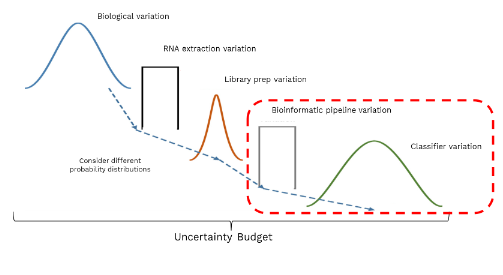

### Imports

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.postprocessing import generate_waterfall_plot
from src.logreg_classifier import antilogit_classifier_score
from src.simulation import MultiUncertaintyResults, simulate_multiple_uncertainties
from src.dtypes import NumpyFloat32Array1D

#### Data loading

The `raw_data` dataframe contains the TPM values for 243 subjects (including technical replicates), along with the coefficients of the classifier. The `pathos` dataframe contains the original categories that the patients belong to.

In [3]:
data_root = Path.cwd().parent.parent / "raw_data"
raw_data = pd.read_excel(
    data_root / "ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    data_root / "Purdue expanded info AD subject sample added Info Apoe.xlsx"
)

In [4]:
raw_data.head()

,gene_id,11174-r1,11178-r1,11182-r1,11182-r2,11186-r1,11186-r2,11190-r1,11190-r2,11194-r1,...,5767-r1,5767-r2,5784-r1,5784-r2,Description,ORI,MIN,MAX,AVG,Coeff
0,ENSG00000079482.12,40.167869,43.221009,102.123100,82.137419,59.941767,13.792904,72.000992,56.627618,68.009413,...,12.370367,2.007663,10.735082,9.461999,OPHN1,1463,0.636022,918.081706,54.796436,0.399459
1,ENSG00000169021.5,4.669515,8.401576,6.827512,9.261443,11.148535,4.445162,5.426358,3.210182,9.386716,...,17.178199,15.817280,11.460425,17.641014,UQCRFS1,12353,0.000000,22.361685,10.534654,0.372143
2,ENSG00000204160.11,91.808686,52.448546,105.386495,48.958301,32.223227,33.497053,29.494519,30.000614,71.504342,...,55.816251,25.256624,58.390142,36.782660,ZDHHC18,17522,4.339465,625.797208,60.139569,0.356649
3,ENSG00000106780.8,44.561230,8.633877,19.836541,21.810697,9.518698,5.770501,9.937019,4.144054,13.294896,...,12.566394,16.028029,15.729589,12.027964,MEGF9,3337,0.836062,151.685905,15.425324,0.311521
4,ENSG00000113303.11,3.803395,2.503695,10.826006,3.646693,7.922817,0.000000,5.855945,5.544861,8.926236,...,0.804744,3.704749,4.051561,0.893506,BTNL8,4136,0.000000,61.493366,5.592945,0.301690


In [5]:
pathos.head()

,Isolate ID,PatientID,Ethnicity,Gender,Disease,MMSE,CDR,Apoe status,Age
0,1817,434,NaN,Female,NCI,30.0,0.0,E3/E3,76.0
1,1818,435,NaN,Female,NCI,30.0,0.0,E2/E4,74.0
2,1821,438,NaN,Female,NCI,29.0,0.0,E3/E3,73.0
3,1850,447,NaN,Male,NCI,29.0,0.0,E3/E4,68.0
4,1854,451,NaN,Female,NCI,29.0,0.0,E3/E4,79.0


For convenience we set the index to the specified columns.

In [6]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

Here we set some parameters that we will use throughout the analysis.

In [7]:
seed = 321  # Random number seed

In [8]:
num_patients = 243  # Total number of samples/subjects/patients

In [9]:
mean_TPM = 10  # When we filter genes for analysis with a reduced feature set,
# we drop genes for which the mean TPM is below this cutoff

In [10]:
single_thres = (
    0.85  # Classifier threshold above which we consider a subject to be in AD category
)
dual_thres_low, dual_thres_high = (
    0.15,
    0.85,
)  # Cut-points for categories (in order) NCI, intermediate, AD

In [11]:
n_samples = 100  # Number of Monte Carlo samples to simulate for each subject
uncertainties = list(
    range(5, 40, 5)
)  # Maximum percentage of noise/uncertainty to simulate. (aka coefficient of variation)

In [12]:
np.random.seed(seed)

#### Data preprocessing

In [13]:
pathos = pathos[pathos["Disease"].notnull()]
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [14]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

The raw dataset contains technical replicates for some subjects. We average the technical replicates to reduce them to a single data point.

In [15]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_189825/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [16]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [17]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [18]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [19]:
patients_df = patients_df.loc[:, pathos.index]

#### Dropping genes below TPM threshold

When analysing a dataset with a reduced set of genes, we keep the genes where the mean TPM value is above the specified cutoff. If the `mean_TPM` value is set to zero, no genes are filtered and the entire dataset is used.

In [20]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [21]:
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

### Performing Monte Carlo simulations

We follow established guidance by the FDA ([Ovarian Adnexal Mass Assessment Score system (2011)](https://www.fda.gov/medical-devices/guidance-documents-medical-devices-and-radiation-emitting-products/ovarian-adnexal-mass-assessment-score-test-system-class-ii-special-controls-guidance-industry-and)) in simulating technical variation in the TPM values.

In general, given a measurement $\mu$, to simulate $k$ % uncertainty ($k$% coefficient of variation/relative standard deviation) we sample from a Gaussian distribution with mean $\mu$ and standard deviation (SD) $kX/100$.

However, for RNA-seq datasets, modeling uncertainty in this fashion with a constant noise level ignores the trend of technical variation commonly observed (e.g. in Fig. 1.(a) from [Law et al (2014)](https://link.springer.com/content/pdf/10.1186/gb-2014-15-2-r29.pdf)).
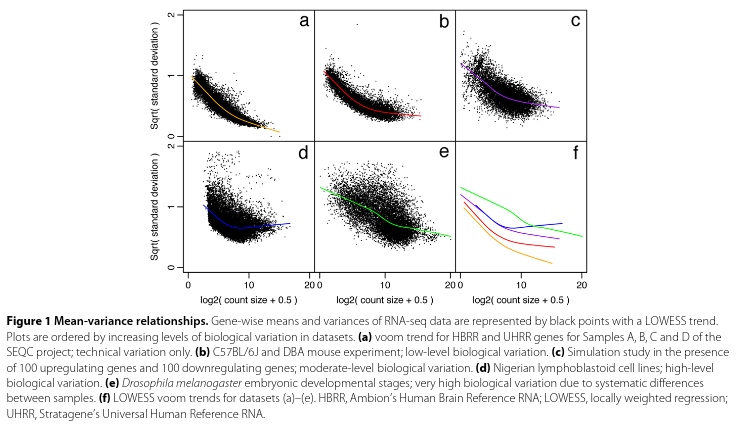

Aligning with Law et al (2014), the relationship between the standard deviation and the mean can be modeled as

$$
\sqrt{\sigma} = \frac{a}{b + \mu} + c
$$

where $\mu$ and $\sigma$ are mean and standard deviation of the $log_2 (1+TPM)$ dataset, respectively and $a$, $b$, $c$ are constants.\\

We start with values of $a$ = 0.75, $b$ = 1.0, $c$ = 0.25, $scaling factor$ = 8.

To generate Monte Carlo TPM samples for a given gene $i$ and subject $j$:

1. Calculate $\sigma_{ij}$ using the SD-mean relationship with $TPM_{ij}$ as the mean:

$$\mu_{ij} = log_{2}(1 + TPM_{ij})$$

$$\sigma_{ij} = (\frac{a}{\mu_{ij} + b} + c)^2$$

$$\sigma_{ij, scaled} = \frac{scaling factor * k * \sigma_{ij}}{100}$$

2. Generate $N$ samples $x_k$ ($k$ = $1…N$) from a Gaussian distribution with mean = $\mu_{ij}$ and standard deviation = $\sigma_{ij}$, scaled.
3. Convert samples to TPM scale by exponentiation:
$$TPM_{k, sampled} = 2^{x_k}$$

In [22]:
def calculate_scaled_sd(
    tpm: float,
    uncertainty_pct: int | float,
    a: float = 0.75,
    b: float = 1.0,
    c: float = 0.25,
    scaling_factor: float = 8.0,
) -> float:
    """
    Calculate scaled standard deviation to simulate based on sqrt sigma = a / (b + mu) + c
    """
    sqrt_sigma = a / (np.log2(tpm + 1) + b) + c
    scaled_pct_sd = scaling_factor * uncertainty_pct * sqrt_sigma**2.0
    return scaled_pct_sd / 100

After generating the simulated measurements we calculate the classifier predictions for these. We then compare the score for the simulated measurement ("simulated score") against the score for the actual measurement ("actual score"). Based on the set threshold(s) we track the classification of the simulated scores against the actual scores.

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score. We track differentially classified subjects under two scenarios
1. at least one of the simulated scores is different from the actual score.
2. at least 10 % of the simulated scores is different from the actual score.

The two different definitions of differential classification track the performance of the classifier under a conservative and a relaxed definition of differential classification.

In [23]:
def sampler(mean: float, rsd: float, n_points: int = 1000) -> NumpyFloat32Array1D:
    """"""
    scaled_sd = calculate_scaled_sd(mean, rsd * 100)
    return np.pow(2.0, np.random.normal(np.log2(mean + 1), scaled_sd, n_points))

In [24]:
res_1_diff_cls: MultiUncertaintyResults = simulate_multiple_uncertainties(
    patients_df,
    sampler,
    uncertainties,
    thres_low=dual_thres_low,
    thres_high=dual_thres_high,
    single_thres=single_thres,
    coefficients=coefficients,
    diff_class_lim=1,
    n_samples=n_samples,
)
res: MultiUncertaintyResults = simulate_multiple_uncertainties(
    patients_df,
    sampler,
    uncertainties,
    thres_low=dual_thres_low,
    thres_high=dual_thres_high,
    single_thres=single_thres,
    coefficients=coefficients,
    diff_class_lim=int(0.10 * n_samples),
    n_samples=n_samples,
)

### Visualization and post-processing

In [25]:
_z_scores = (
    patients_df.values - patients_df.mean(axis=1).values.reshape(-1, 1)
) / patients_df.std(axis=1).values.reshape(-1, 1)
gt_probs = antilogit_classifier_score(
    np.sum(coefficients[:, np.newaxis] * _z_scores, axis=0)
)
gt_probs = pd.Series(index=patients_df.columns, data=gt_probs)

In [26]:
def visualize_differential_classification_results(
    results: pd.DataFrame,
    title: str,
    show_axis_labels: bool = True,
    show_legend: bool = True,
) -> None:
    for cat in results.columns:
        plt.plot(results.index, results.loc[:, cat], label=cat)
    if show_axis_labels:
        plt.xlabel("Pct. uncertainty")
        plt.ylabel("Percent of subjects within category differentially classified")
    plt.title(title)
    if show_legend:
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))

Text(0.5, -0.06, 'Classifier predictions: 95 AD, 148 NCI subjects')

<Figure size 1600x600 with 0 Axes>

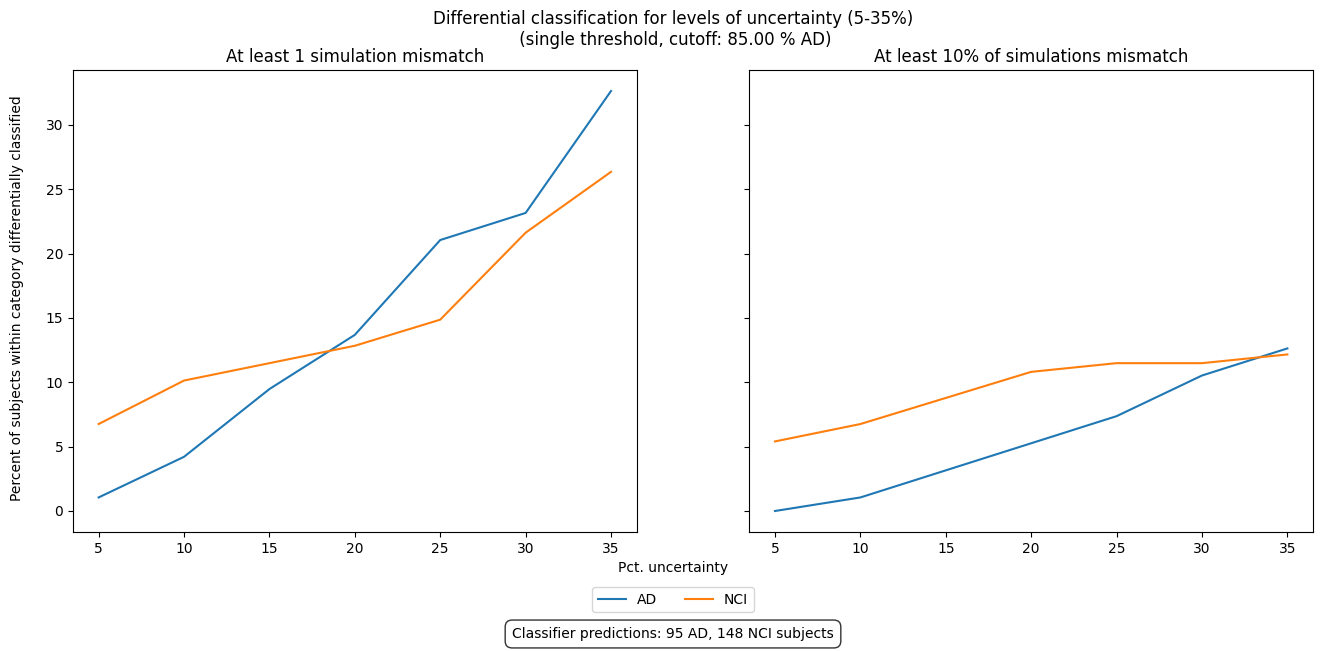

In [27]:
num_AD, num_NCI = (single_thres <= gt_probs).sum(), (single_thres > gt_probs).sum()
single_thres_pct_diff_cls_1_diff_cls = res_1_diff_cls.single_thres_expt_results.copy(
    deep=True
)
single_thres_pct_diff_cls_1_diff_cls["AD"] = (
    single_thres_pct_diff_cls_1_diff_cls["AD"].apply(len) / num_AD * 100
)
single_thres_pct_diff_cls_1_diff_cls["NCI"] = (
    single_thres_pct_diff_cls_1_diff_cls["NCI"].apply(len) / num_NCI * 100
)
single_thres_pct_diff_cls = res.single_thres_expt_results.copy(deep=True)
single_thres_pct_diff_cls["AD"] = (
    single_thres_pct_diff_cls["AD"].apply(len) / num_AD * 100
)
single_thres_pct_diff_cls["NCI"] = (
    single_thres_pct_diff_cls["NCI"].apply(len) / num_NCI * 100
)
fig = plt.figure(figsize=(16, 6))
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 6))
plt.subplot(121)
visualize_differential_classification_results(
    single_thres_pct_diff_cls_1_diff_cls, "At least 1 simulation mismatch", False, False
)
plt.subplot(122)
visualize_differential_classification_results(
    single_thres_pct_diff_cls, "At least 10% of simulations mismatch", False, False
)
leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
fig.legend(
    leg_handles,
    leg_labels,
    loc="upper center",
    ncol=len(leg_labels),
    bbox_to_anchor=(0.5, 0.03),
)
fig.text(0.5, 0.05, "Pct. uncertainty", va="center", ha="center")
fig.text(
    0.09,
    0.5,
    "Percent of subjects within category differentially classified",
    va="center",
    ha="center",
    rotation="vertical",
)
fig.suptitle(
    f"Differential classification for levels of uncertainty (5-35%)\n (single threshold, cutoff: {single_thres * 100:.2f} % AD)"
)
fig.text(
    0.5,
    -0.06,
    f"Classifier predictions: {num_AD} AD, {num_NCI} NCI subjects",
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round,pad=0.5", facecolor="white", edgecolor="black", alpha=0.8
    ),
)

Text(0.5, -0.06, 'Classifier predictions: 95 AD, 28 Intermediate, 120 NCI subjects')

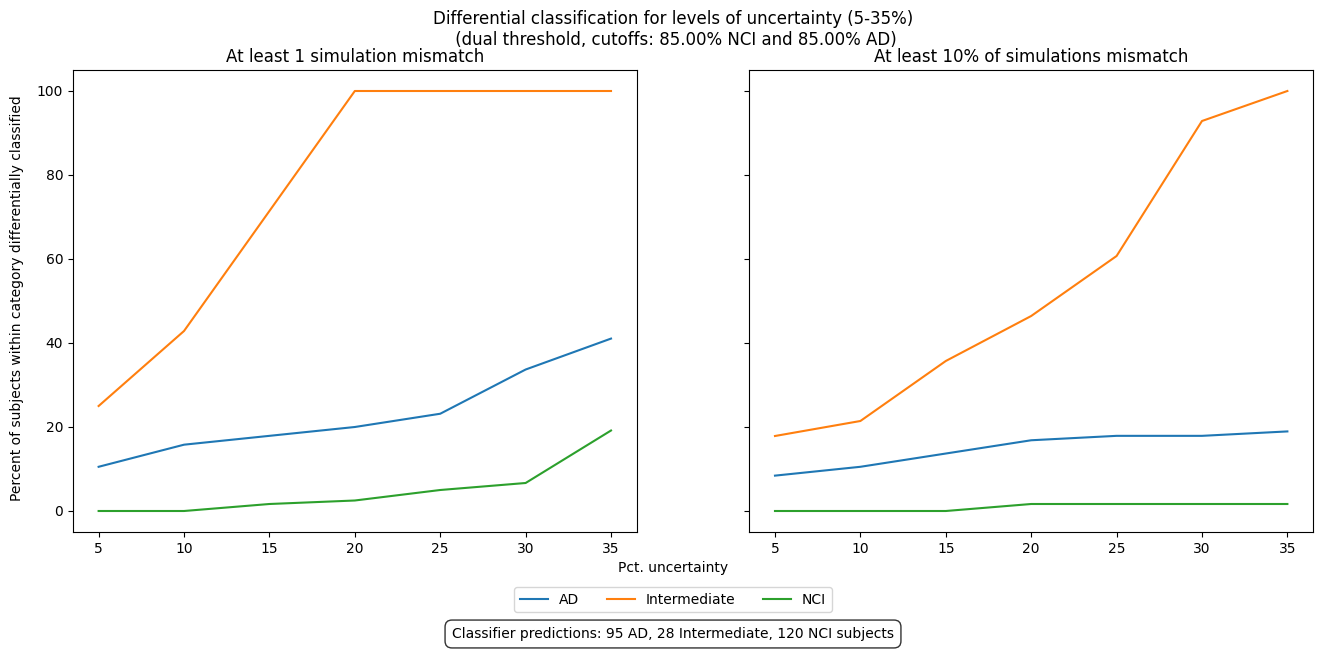

In [28]:
num_AD, num_interm, num_NCI = (
    (dual_thres_high <= gt_probs).sum(),
    ((dual_thres_low <= gt_probs) & (gt_probs < dual_thres_high)).sum(),
    (dual_thres_low > gt_probs).sum(),
)
two_thres_pct_diff_cls_1_diff_cls = res_1_diff_cls.dual_thres_expt_results.copy(
    deep=True
)
two_thres_pct_diff_cls_1_diff_cls["AD"] = (
    two_thres_pct_diff_cls_1_diff_cls["AD"].apply(len) / num_AD * 100
)
two_thres_pct_diff_cls_1_diff_cls["Intermediate"] = (
    two_thres_pct_diff_cls_1_diff_cls["Intermediate"].apply(len) / num_interm * 100
)
two_thres_pct_diff_cls_1_diff_cls["NCI"] = (
    two_thres_pct_diff_cls_1_diff_cls["NCI"].apply(len) / num_NCI * 100
)

two_thres_pct_diff_cls = res.dual_thres_expt_results.copy(deep=True)
two_thres_pct_diff_cls["AD"] = two_thres_pct_diff_cls["AD"].apply(len) / num_AD * 100
two_thres_pct_diff_cls["Intermediate"] = (
    two_thres_pct_diff_cls["Intermediate"].apply(len) / num_interm * 100
)
two_thres_pct_diff_cls["NCI"] = two_thres_pct_diff_cls["NCI"].apply(len) / num_NCI * 100
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16, 6))
plt.subplot(121)
visualize_differential_classification_results(
    two_thres_pct_diff_cls_1_diff_cls, "At least 1 simulation mismatch", False, False
)
plt.subplot(122)
visualize_differential_classification_results(
    two_thres_pct_diff_cls, "At least 10% of simulations mismatch", False, False
)
leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
fig.legend(
    leg_handles,
    leg_labels,
    loc="upper center",
    ncol=len(leg_labels),
    bbox_to_anchor=(0.5, 0.03),
)
fig.text(0.5, 0.05, "Pct. uncertainty", va="center", ha="center")
fig.text(
    0.09,
    0.5,
    "Percent of subjects within category differentially classified",
    va="center",
    ha="center",
    rotation="vertical",
)
fig.suptitle(
    "Differential classification for levels of uncertainty (5-35%)\n"
    f" (dual threshold, cutoffs: {(1 - dual_thres_low) * 100:.2f}% NCI and {dual_thres_high * 100:.2f}% AD)"
)
fig.text(
    0.5,
    -0.06,
    f"Classifier predictions: {num_AD} AD, {num_interm} Intermediate, {num_NCI} NCI subjects",
    ha="center",
    va="center",
    bbox=dict(
        boxstyle="round,pad=0.5", facecolor="white", edgecolor="black", alpha=0.8
    ),
)

In [29]:
from typing import Literal
from itertools import product


def get_gender_and_diagnosis_patient_ids(
    pathos_df: pd.DataFrame,
    pred_labels: pd.Series,
    gender: Literal["Male", "Female"],
    diagnosis: int,
) -> list[int]:
    """ """
    gender_patient_ids = set(pathos_df[pathos_df["Gender"] == gender].index)
    diagnosis_patient_ids = set(pred_labels[pred_labels == diagnosis].index)
    return gender_patient_ids.intersection(diagnosis_patient_ids)

In [30]:
labels = ["NCI", "Intermediate", "AD"]
labels_dict = {}
for i, item in enumerate(product(["Male", "Female"], range(len(labels)))):
    labels_dict[i] = f"{item[0]}, {labels[item[1]]}"

In [31]:
def get_gender_pred_labels(
    pred_labels: pd.Series,
    pathos_df: pd.DataFrame,
) -> pd.Series:
    """"""
    gender_pred_labels = pred_labels.copy(deep=True)
    for i, item in enumerate(
        product(["Male", "Female"], np.sort(pred_labels.unique()))
    ):
        gender_pred_labels.loc[
            list(
                get_gender_and_diagnosis_patient_ids(
                    pathos_df, pred_labels, item[0], item[1]
                )
            )
        ] = i
    return gender_pred_labels

In [32]:
from sklearn.metrics import jaccard_score


def build_gender_pred_labels_dict(
    pred_labels_dict: dict[int, pd.Series], pathos_df: pd.DataFrame
) -> dict[int, pd.Series]:
    """"""
    gender_pred_labels_dict = {}
    for uncert in pred_labels_dict:
        gender_pred_labels_dict[uncert] = get_gender_pred_labels(
            pred_labels_dict[uncert], pathos_df
        )
    return gender_pred_labels_dict


def calculate_jaccard_index(
    *, labels: list[str], gt_labels: pd.Series, pred_labels_dict: dict[int, pd.Series]
) -> pd.DataFrame:
    """"""
    jaccard_index = pd.DataFrame(
        index=list(pred_labels_dict.keys()), columns=list(labels)
    )
    jaccard_index.loc[0, :] = np.ones(len(labels))
    for uncert in pred_labels_dict:
        jaccard_index.loc[uncert, :] = jaccard_score(
            pred_labels_dict[uncert].values,
            gt_labels.values,
            average=None,
        )
    return jaccard_index


def plot_jaccard_index_plot(
    *,
    labels_dict_single_thres: dict[str, str],
    labels_dict_dual_thres: dict[str, str],
    gt_labels_single_thres: pd.Series,
    gt_labels_dual_thres: pd.Series,
    pred_labels_dict_single_thres: dict[int, pd.Series],
    pred_labels_dict_dual_thres: dict[int, pd.Series],
    single_thres_plot_title: str,
    dual_thres_plot_title: str,
    figure_title: str,
) -> None:
    """ """
    for label in labels_dict_single_thres:
        if labels_dict_single_thres[label] != labels_dict_dual_thres[label]:
            raise ValueError(f"Difference in linestyle between single and dual threshold plots for label '{label}'")
    fig, axs = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=True)
    plt.subplot(121)
    jac_idx_df = calculate_jaccard_index(
        labels=list(labels_dict_single_thres.keys()),
        gt_labels=gt_labels_single_thres,
        pred_labels_dict=pred_labels_dict_single_thres,
    )
    x_vals = np.sort(jac_idx_df.index.values)
    for col in jac_idx_df.columns:
        plt.plot(
            x_vals,
            jac_idx_df.loc[x_vals, col],
            label=col,
            color=labels_dict_single_thres[col],
        )

    plt.legend()
    plt.title(single_thres_plot_title)
    
    plt.subplot(122)
    jac_idx_df = calculate_jaccard_index(
        labels=list(labels_dict_dual_thres.keys()),
        gt_labels=gt_labels_dual_thres,
        pred_labels_dict=pred_labels_dict_dual_thres,
    )
    x_vals = np.sort(jac_idx_df.index.values)
    for col in jac_idx_df.columns:
        plt.plot(
            x_vals,
            jac_idx_df.loc[x_vals, col],
            label=col,
            color=labels_dict_dual_thres[col],
        )
    plt.legend()
    plt.title(dual_thres_plot_title)
    fig.text(
        0.09,
        0.5,
        "Jaccard index",
        va="center",
        ha="center",
        rotation="vertical",
    )
    fig.text(0.5, 0.05, "Pct. uncertainty", va="center", ha="center")
    leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
    fig.legend(
        leg_handles,
        leg_labels,
        loc="upper center",
        ncol=2,
        bbox_to_anchor=(0.5, 0.03),
    )
    fig.suptitle(figure_title)

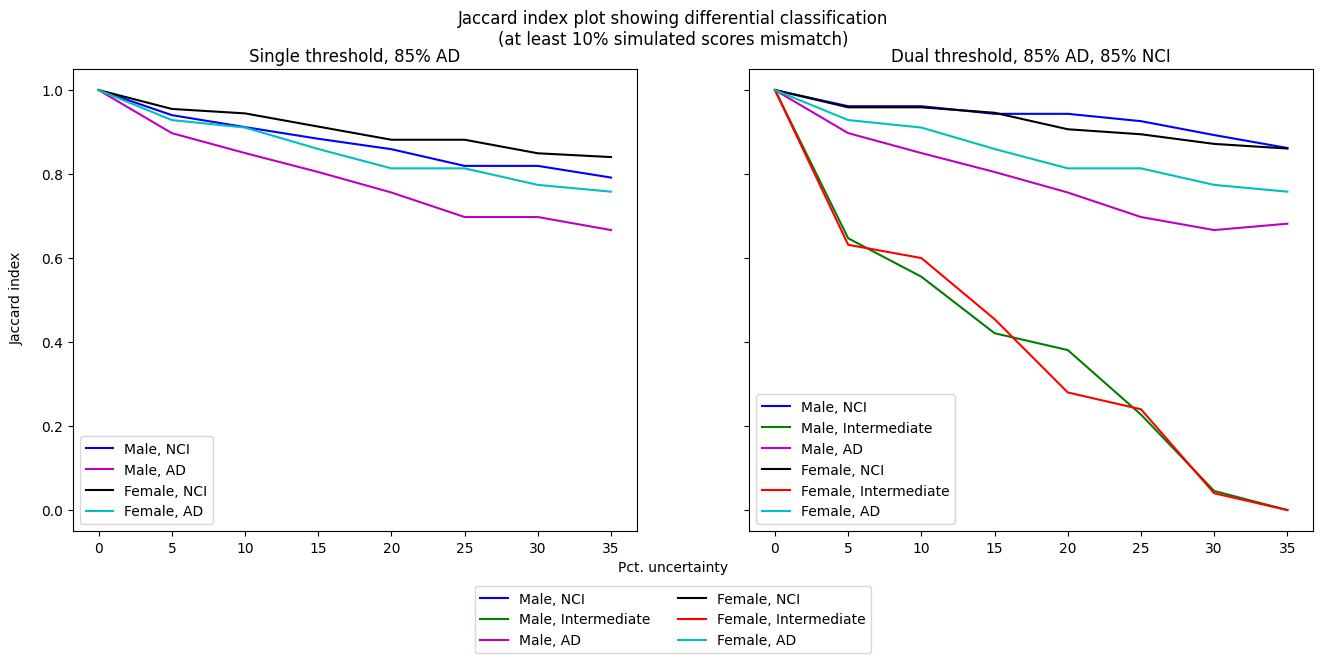

In [33]:
plot_jaccard_index_plot(
    labels_dict_single_thres={
        label: color
        for color, label in zip(
            "bmkc",
            map(
                lambda x: f"{x[0]}, {x[1]}",
                product(["Male", "Female"], ["NCI", "AD"]),
            ),
        )
    },
    labels_dict_dual_thres={
        label: color
        for color, label in zip(
            "bgmkrc",
            map(
                lambda x: f"{x[0]}, {x[1]}",
                product(["Male", "Female"], ["NCI", "Intermediate", "AD"]),
            ),
        )
    },
    gt_labels_single_thres=get_gender_pred_labels(
        res.single_thres_gt_labels[uncertainties[0]], pathos
    ),
    gt_labels_dual_thres=get_gender_pred_labels(
        res.dual_thres_gt_labels[uncertainties[0]], pathos
    ),
    pred_labels_dict_single_thres=build_gender_pred_labels_dict(
        res.single_thres_pred_labels, pathos
    ),
    pred_labels_dict_dual_thres=build_gender_pred_labels_dict(
        res.dual_thres_pred_labels, pathos
    ),
    single_thres_plot_title="Single threshold, 85% AD",
    dual_thres_plot_title="Dual threshold, 85% AD, 85% NCI",
    figure_title="Jaccard index plot showing differential classification\n(at least 10% simulated scores mismatch)",
)

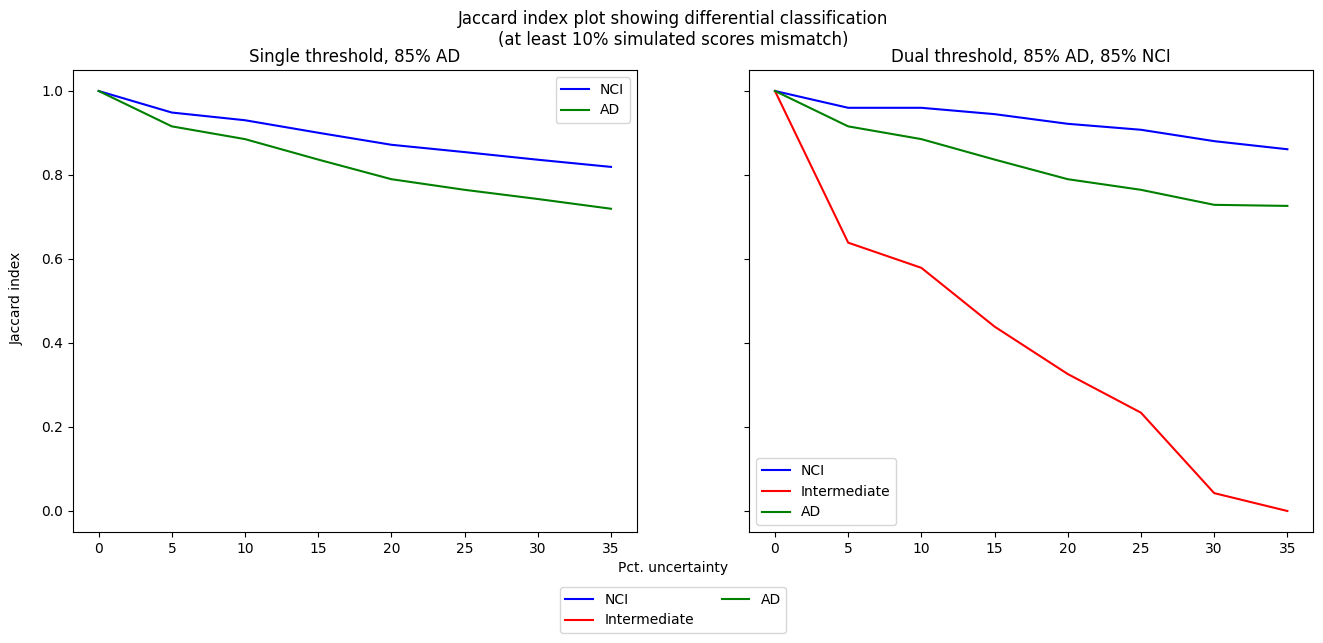

In [34]:
plot_jaccard_index_plot(
    labels_dict_single_thres={"NCI": "b", "AD": "g"},
    labels_dict_dual_thres={"NCI": "b", "Intermediate": "r", "AD": "g"},
    gt_labels_single_thres=res.single_thres_gt_labels[uncertainties[0]],
    gt_labels_dual_thres=res.dual_thres_gt_labels[uncertainties[0]],
    pred_labels_dict_single_thres=res.single_thres_pred_labels,
    pred_labels_dict_dual_thres=res.dual_thres_pred_labels,
    single_thres_plot_title="Single threshold, 85% AD",
    dual_thres_plot_title="Dual threshold, 85% AD, 85% NCI",
    figure_title="Jaccard index plot showing differential classification\n(at least 10% simulated scores mismatch)",
)

In [35]:
def plot_waterfall_plot_for_gender_data(
    *,
    threshold: float,
    probs: pd.Series,
    pathos_df: pd.DataFrame,
    pred_labels: pd.Series,
    uncertainty: int,
) -> None:
    labels_dict = {
        i: f"{item[0]}, {item[1]}"
        for i, item in enumerate(product(["Male", "Female"], ["NCI", "AD"]))
    }
    generate_waterfall_plot(
        threshold=threshold,
        probs=probs,
        color_labels_data=get_gender_pred_labels(pred_labels, pathos_df),
        labels=labels_dict,
        colors=["#123456", "#fedabc", "#345dab", "#d1a2b3"],
        title=f"Waterfall plot showing simulated and inferent scores\n at {uncertainty}% simulated uncertainty",
        legend_title="Simulated score\n   predictions",
    )

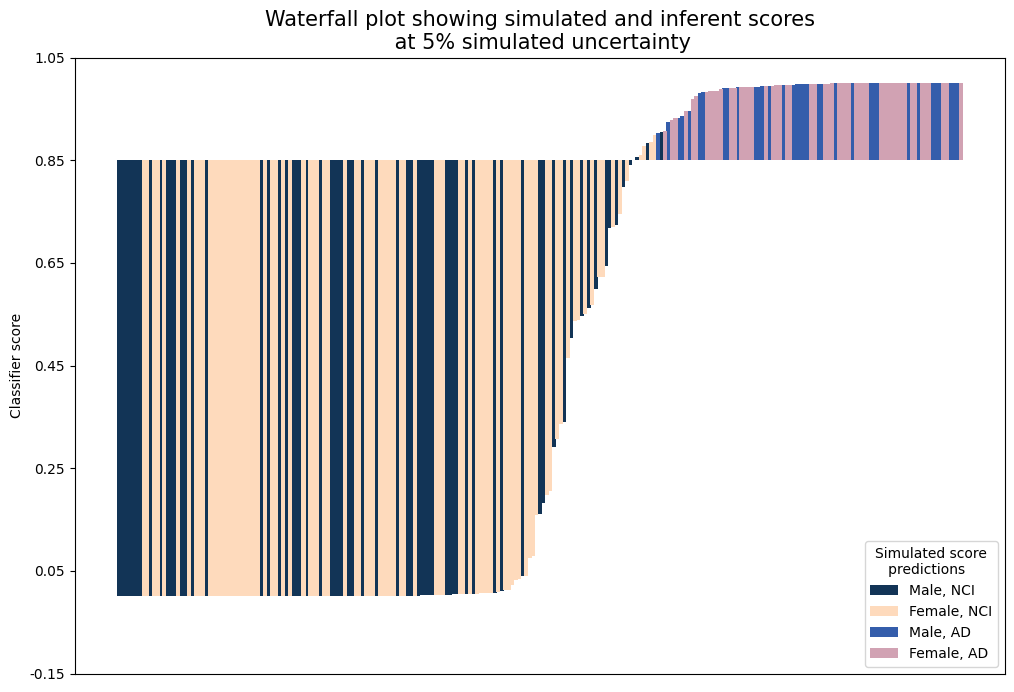

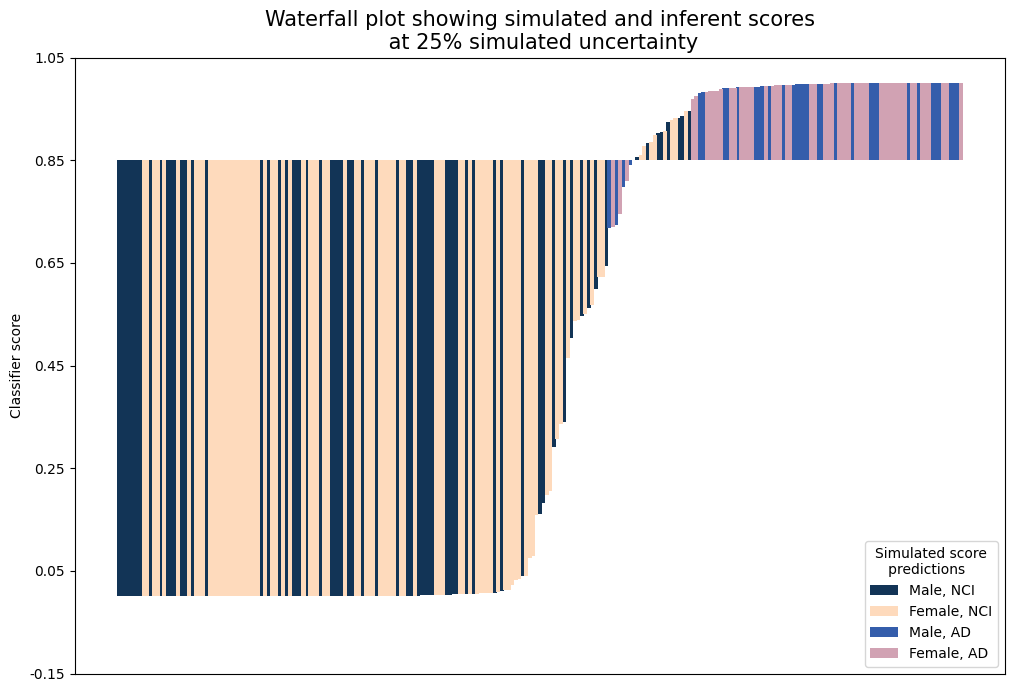

In [36]:
plot_waterfall_plot_for_gender_data(
    threshold=single_thres,
    probs=gt_probs,
    pathos_df=pathos,
    pred_labels=res.single_thres_pred_labels[5],
    uncertainty=5,
)
plot_waterfall_plot_for_gender_data(
    threshold=single_thres,
    probs=gt_probs,
    pathos_df=pathos,
    pred_labels=res.single_thres_pred_labels[25],
    uncertainty=25,
)

### References

1. Beaver et al. "An FDA Perspective on the Regulatory Implications of Complex Signatures to Predict Response to Targeted Therapies." _Clin Cancer Res. 2017 Mar 15;23(6):1368-1372._
2. Braga and Panteghini "The utility of measurement uncertainty in medical laboratories" _Clin Chem Lab Med 2020; 58(9):1407-1413_.
3. Law, Charity W., et al. "voom: Precision weights unlock linear model analysis tools for RNA-seq read counts." _Genome biology 15 (2014): 1-17_.
4. Petraco, Ricardo, et al. "Effects of disease severity distribution on the performance of quantitative diagnostic methods and proposal of a novel ‘V-plot’methodology to display accuracy values." _Open Heart 5.1 (2018): e000663_.
5. Plebani et al. "Measurement uncertainty: light in the shadows" _Clin Chem Lab Med 2020; 58(9):1381-1383_.
6. Song et al. "Anvil – System Architecture and Experiences from Deployment and Early User Operations" _PEARC July (2022)_.
7. Theodorsson E. "Uncertainty in Measurement and Total Error: Tools for Coping with Diagnostic Uncertainty." _Clin Lab Med. 2017 Mar;37(1):15-34_.
8. Toden et al. "Noninvasive characterization of Alzheimer's disease by circulating, cell-free messenger RNA next-generation sequencing." _Sci Adv. 2020 Dec 9;6(50):eabb1654_.
9. Tong et al. "Impact of RNA-seq data analysis algorithms on gene expression estimation and downstream prediction." _Sci Rep. 2020 Oct 21;10(1):17925_.